## 1 Import libraries

In [292]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import eli5

In [293]:
# function based on DataWorkshop masterclass excercise
def check_log_model(df, feats, model, cv=5, scoring=mean_squared_error, show_eli5=True):
    df_train = df[ ~df['SalePrice'].isnull() ].copy()

    X = df_train[feats]
    y = df_train['SalePrice']
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = scoring(y_test, y_pred, squared=False)
        scores.append(score)
        
    result = np.mean(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)

    return result

## 2 Load data

In [294]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [295]:
print('the train df has a shape of: ', df_train.shape)
print('the test df has a shape of: ', df_test.shape)

the train df has a shape of:  (1460, 81)
the test df has a shape of:  (1459, 80)


In [296]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [297]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## 3 Data preliminary analysis

In [298]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

NOTES
 
ordered categorical:
OverallCond, OverallQual, LotShape, Utilities, LandSlope, OverallQual, OverallCond, ExterQual, ExterCond, BsmtQual, BsmtFinSF1, BsmtFinSF2, HeatingQC, HeatingQC, KitchenQual, Functional, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive

Other
47  BsmtFullBath   1460 non-null   int64  
48  BsmtHalfBath   1460 non-null   int64 -> combine and count half bath as 0.5
49  FullBath       1460 non-null   int64  
50  HalfBath       1460 non-null   int64 -> combine and count half bath as 0.5

living space / room
Bathrooms / room -> additional feature
garage area / nr of cars
 66  WoodDeckSF     1460 non-null   int64  -> consider combining into one feature giving different kinds of porches/decks differen weights 
67  OpenPorchSF    1460 non-null   int64  
68  EnclosedPorch  1460 non-null   int64  
69  3SsnPorch      1460 non-null   int64  
70  ScreenPorch    1460 non-null   int64 
71  PoolArea       1460 non-null   int64  -> consider combining into 1 binary feature (Pool Yes/No)
72  PoolQC         7 non-null      object 

MiscVal: $Value of miscellaneous feature ? think what to do with this - remove from price and also remove the feature from modelling?
 
76  MoSold         1460 non-null   int64  
77  YrSold         1460 non-null   int64  -> combine into datetime objects?

Consider k-clustering
Neighborhood

## 4 pre-processing data

In [299]:
# create combined df from test and train data to perform cleaning simultaneously

df = pd.concat([df_train, df_test])
print(df.shape)

(2919, 81)


In [300]:
# change None value to np.NaN
df.replace(to_replace='None', value=np.nan, inplace=True)
df.MasVnrType.value_counts()

BrkFace    879
Stone      249
BrkCmn      25
Name: MasVnrType, dtype: int64

In [301]:
# change data type for MSSubClass OverallQual and OverallCond to object
df[['MSSubClass', 'OverallQual', 'OverallCond']] = df[['MSSubClass', 'OverallQual', 'OverallCond']].astype('object')

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   object 
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   object 
 18  OverallC

In [303]:
# get names of columns with object dtype
obj_feats = df.select_dtypes(object).columns
obj_feats, len(obj_feats)

(Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
        'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
        'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
       dtype='object'),
 46)

In [304]:
num_feats = df.select_dtypes('number').columns
num_feats = [x for x in num_feats if "SalePrice" not in x and "Id" not in x]
num_feats

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [305]:
#checking if we have all feats except price and Id in the respective lists
df.shape[1] - len(obj_feats) - len(num_feats)

2

In [306]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,2919.000,1460.000,842.787,1.000,730.500,1460.000,2189.500,2919.000
LotFrontage,2433.000,69.306,23.345,21.000,59.000,68.000,80.000,313.000
LotArea,2919.000,10168.114,7886.996,1300.000,7478.000,9453.000,11570.000,215245.000
YearBuilt,2919.000,1971.313,30.291,1872.000,1953.500,1973.000,2001.000,2010.000
YearRemodAdd,2919.000,1984.264,20.894,1950.000,1965.000,1993.000,2004.000,2010.000
MasVnrArea,2896.000,102.201,179.334,0.000,0.000,0.000,164.000,1600.000
BsmtFinSF1,2918.000,441.423,455.611,0.000,0.000,368.500,733.000,5644.000
BsmtFinSF2,2918.000,49.582,169.206,0.000,0.000,0.000,0.000,1526.000
BsmtUnfSF,2918.000,560.772,439.544,0.000,220.000,467.000,805.500,2336.000
TotalBsmtSF,2918.000,1051.778,440.766,0.000,793.000,989.500,1302.000,6110.000


In [307]:
# factorizing categorical variables & extracting a list of cat_variables to use in model
for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]
cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

['MSSubClass_cat',
 'MSZoning_cat',
 'Street_cat',
 'Alley_cat',
 'LotShape_cat',
 'LandContour_cat',
 'Utilities_cat',
 'LotConfig_cat',
 'LandSlope_cat',
 'Neighborhood_cat',
 'Condition1_cat',
 'Condition2_cat',
 'BldgType_cat',
 'HouseStyle_cat',
 'OverallQual_cat',
 'OverallCond_cat',
 'RoofStyle_cat',
 'RoofMatl_cat',
 'Exterior1st_cat',
 'Exterior2nd_cat',
 'MasVnrType_cat',
 'ExterQual_cat',
 'ExterCond_cat',
 'Foundation_cat',
 'BsmtQual_cat',
 'BsmtCond_cat',
 'BsmtExposure_cat',
 'BsmtFinType1_cat',
 'BsmtFinType2_cat',
 'Heating_cat',
 'HeatingQC_cat',
 'CentralAir_cat',
 'Electrical_cat',
 'KitchenQual_cat',
 'Functional_cat',
 'FireplaceQu_cat',
 'GarageType_cat',
 'GarageFinish_cat',
 'GarageQual_cat',
 'GarageCond_cat',
 'PavedDrive_cat',
 'PoolQC_cat',
 'Fence_cat',
 'MiscFeature_cat',
 'SaleType_cat',
 'SaleCondition_cat']

In [308]:
# in the statistics returned by .describe() I can see that the maximum year for garage remodelling is false (2207)
# let's see what could be a plausible explanation
df.loc[df.GarageYrBlt == 2207.000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,MSSubClass_cat,MSZoning_cat,Street_cat,Alley_cat,LotShape_cat,LandContour_cat,Utilities_cat,LotConfig_cat,LandSlope_cat,Neighborhood_cat,Condition1_cat,Condition2_cat,BldgType_cat,HouseStyle_cat,OverallQual_cat,OverallCond_cat,RoofStyle_cat,RoofMatl_cat,Exterior1st_cat,Exterior2nd_cat,MasVnrType_cat,ExterQual_cat,ExterCond_cat,Foundation_cat,BsmtQual_cat,BsmtCond_cat,BsmtExposure_cat,BsmtFinType1_cat,BsmtFinType2_cat,Heating_cat,HeatingQC_cat,CentralAir_cat,Electrical_cat,KitchenQual_cat,Functional_cat,FireplaceQu_cat,GarageType_cat,GarageFinish_cat,GarageQual_cat,GarageCond_cat,PavedDrive_cat,PoolQC_cat,Fence_cat,MiscFeature_cat,SaleType_cat,SaleCondition_cat
1132,2593,20,RL,68.000,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,nan,Gd,TA,PConc,Gd,TA,Av,GLQ,583.000,Unf,0.000,963.000,1546.000,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.000,0.000,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.000,RFn,2.000,502.000,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,nan,1,0,0,-1,1,3,0,0,0,16,0,0,0,1,2,0,1,0,0,0,-1,0,0,0,0,0,3,0,0,0,0,0,0,2,0,1,0,0,0,0,0,-1,-1,-1,1,2


In [309]:
# it seems that this is a typo; house was built in 2006 and remodelling was 2007, so probably 2007 is the correct remodellinh year. Let's fix this
df.loc[df.GarageYrBlt == 2207.000, 'GarageYrBlt'] = 2007

In [310]:
# check
print(df.loc[df.Id == 2593]['GarageYrBlt'])
df.GarageYrBlt.describe()

1132   2007.000
Name: GarageYrBlt, dtype: float64


count   2760.000
mean    1978.041
std       25.206
min     1895.000
25%     1960.000
50%     1979.000
75%     2002.000
max     2010.000
Name: GarageYrBlt, dtype: float64

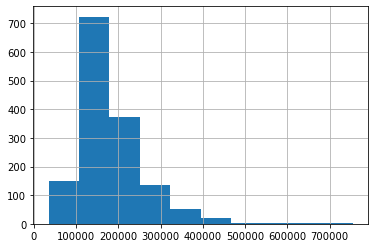

In [311]:
# let's check the distribution of the target variable
df.SalePrice.hist();

The distribution of the sale price is right skewed, with most sale prices ranging between 100-200k and top values reaching almost 800k (no indication with regards to unit but probably kUSD). Let's see how it would look like after using log transformation.

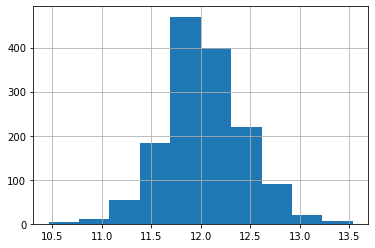

In [312]:
np.log(df.SalePrice).hist();

The distribution is much more symmetric, so I'll use the log transform to build the model.

## 5 Building baseline model and feature engineering

### 5.1 Baseline model

In [313]:
# defining features set to be used in the baseline model
feats = num_feats + cat_feats

In [314]:
# building baseline model using check_log_model
#check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=400, learning_rate=0.3, random_state=0))

Baseline model using log transformation of the target variable and all available categorical and numeric variables without any transformation resulted in an RMSE of ca. 31.200. Let's assign this value to a variable for reference.

In [315]:
baseline_rmse = 31181.425130590545

### 5.2 Log transformation of numeric variables 

In [316]:
# define function to gegerate paralell plots of variable original distribution and log transform distribution for comparison
def plot_logpair(feat, bins=20):
    ''' plots a pair of histograms for a variable feat: original distribution histogram and log transform histogram'''
    plt.figure(figsize=[10,3])
    plt.subplot(1,2,1)
    df[feat].hist(bins=20)
    plt.title('original distribution of {}'.format(feat))
    plt.subplot(1,2,2)
    np.log(df.LotArea).hist(bins=20)
    plt.title('log transform distribution of {}'.format(feat))
    pass

In [317]:
# define num feats to check benefits of log transformation
num_log_check = ['LotFrontage',  'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                 '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                 'ScreenPorch', 'PoolArea']

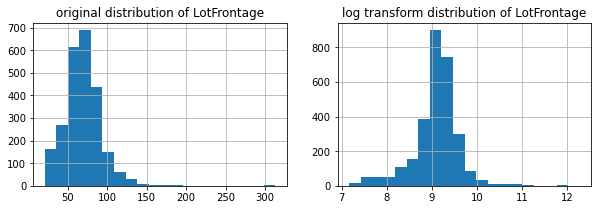

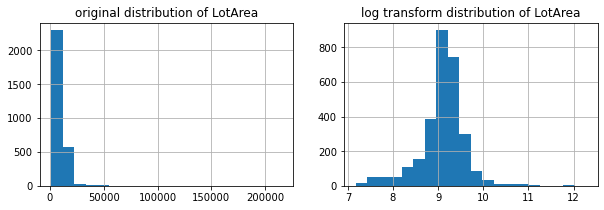

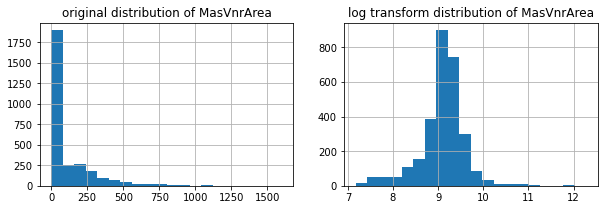

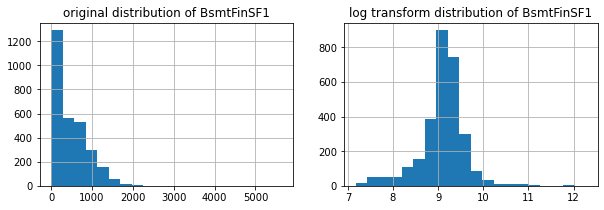

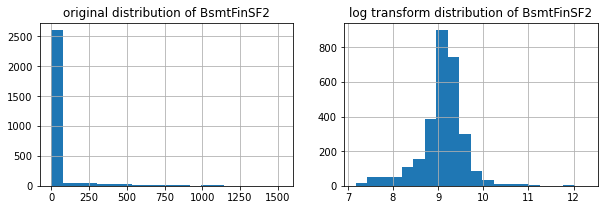

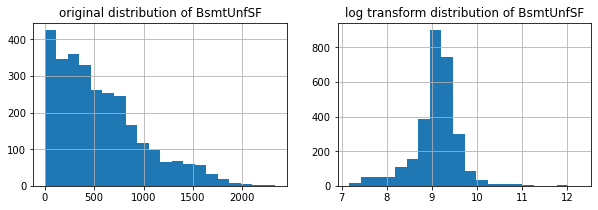

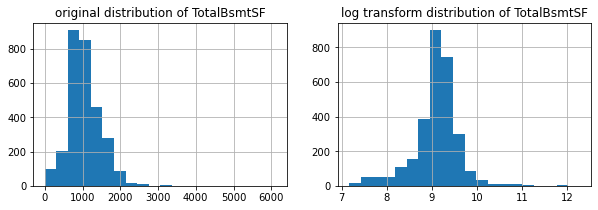

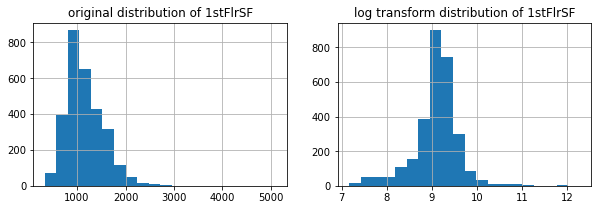

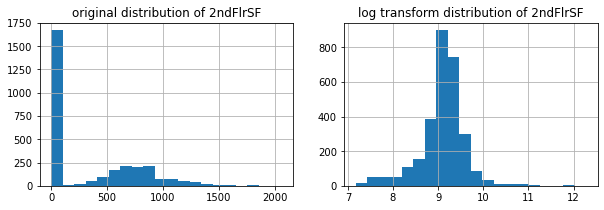

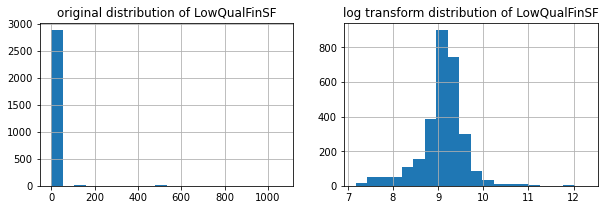

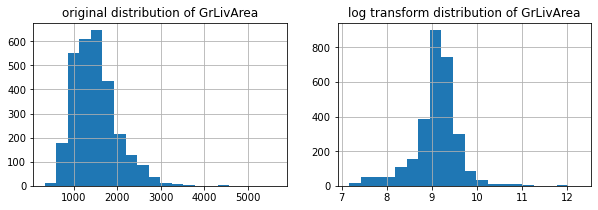

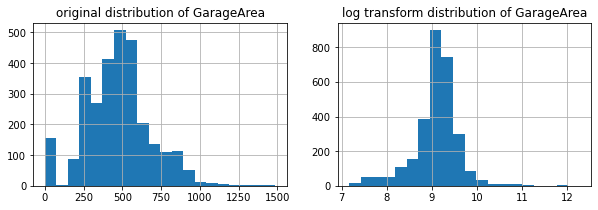

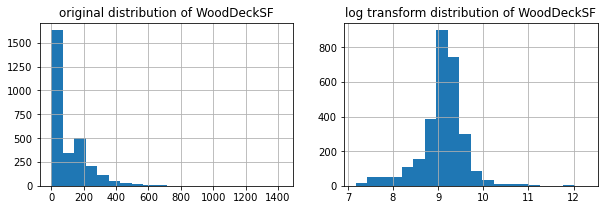

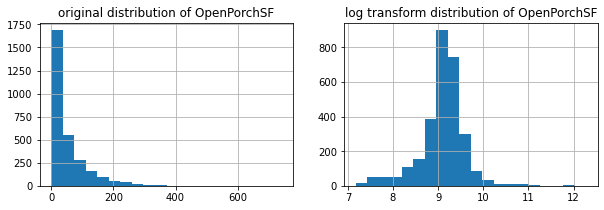

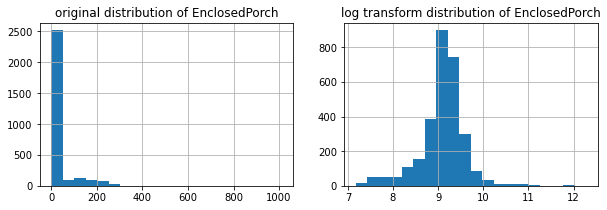

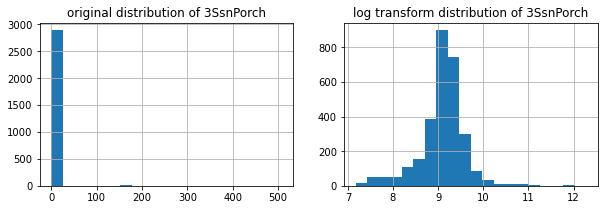

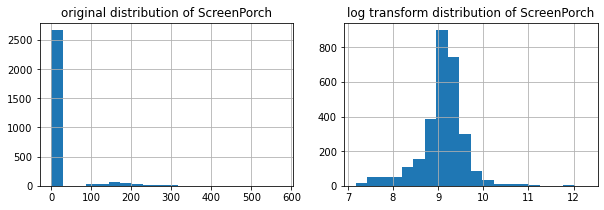

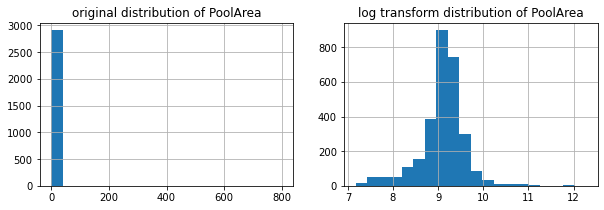

In [318]:
# plot paralell charts
for i in num_log_check:
    plot_logpair(i);

The above charts show that there should be a benefit to log transforming all numeric variables included in num_log_check as there is a visible normalization of distributions across all variables in question

In [319]:
# create log transform equivalents for all features in num_log_check (add +1 to avoid log transform of 0 values errors)

for i in num_log_check:
    df['{}_log'.format(i)] = np.log(df[i]+1)
    

In [320]:
log_feats = [x for x in df.columns if "_log" in x]

In [321]:
# adding log_feats to feats list
feats = feats + log_feats
# removing all original feats that were log transformed 
feats = [feat for feat in feats if feat not in num_log_check]

In [322]:
df.LotFrontage.isnull().sum()

486

In [323]:
df[log_feats].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage_log    2433 non-null   float64
 1   LotArea_log        2919 non-null   float64
 2   MasVnrArea_log     2896 non-null   float64
 3   BsmtFinSF1_log     2918 non-null   float64
 4   BsmtFinSF2_log     2918 non-null   float64
 5   BsmtUnfSF_log      2918 non-null   float64
 6   TotalBsmtSF_log    2918 non-null   float64
 7   1stFlrSF_log       2919 non-null   float64
 8   2ndFlrSF_log       2919 non-null   float64
 9   LowQualFinSF_log   2919 non-null   float64
 10  GrLivArea_log      2919 non-null   float64
 11  GarageArea_log     2918 non-null   float64
 12  WoodDeckSF_log     2919 non-null   float64
 13  OpenPorchSF_log    2919 non-null   float64
 14  EnclosedPorch_log  2919 non-null   float64
 15  3SsnPorch_log      2919 non-null   float64
 16  ScreenPorch_log    2919 

In [324]:
# check model after log transforming numeric variables
# check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=400, learning_rate=0.3, random_state=0))

30620.91317121286


Weight,Feature
0.2654,CentralAir_cat
0.1366,GarageCars
0.0628,Fireplaces
0.0530,GrLivArea_log
0.0495,TotalBsmtSF_log
0.0463,RoofMatl_cat
0.0370,KitchenQual_cat
0.0292,MSZoning_cat
0.0278,KitchenAbvGr
0.0230,YearBuilt


In [325]:
print('The introduction of log transformed numeric variables improved the error by {}'.format(baseline_rmse - 30620.91))

The introduction of log transformed numeric variables improved the error by 560.5151305905456


### 5.3 Aggregating features related to number / area of rooms and other surfaces

Bathrooms / room -> additional feature
garage area / nr of cars
71  PoolArea       1460 non-null   int64  -> consider combining into 1 binary feature (Pool Yes/No)
72  PoolQC         7 non-null      object 

In [326]:
# aggregate nr of baths in Bsmt and above ground, count half bath as 0.5
df['NrBsmtBath'] = df.BsmtFullBath + 0.5 * df.BsmtHalfBath
df['NrBath'] = df.FullBath + 0.5 * df.HalfBath

# aggregate all baths assigning 0.7 to basement bath number
df['BathAgg'] = df['NrBsmtBath'] * 0.7 + df['NrBath']

In [327]:
# living space per room
df['LivingSpcPerRoom'] = df.GrLivArea / df.TotRmsAbvGrd

<AxesSubplot:>

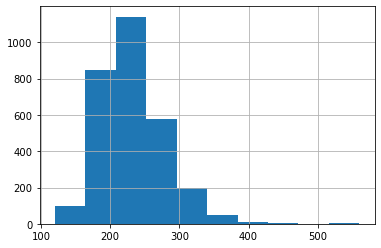

In [338]:
df.LivingSpcPerRoom.hist()

In [330]:
# aggregate outdoor deck / porch space into one feature
# As 3Ssn Porch area is equivalent to regular living space it will have a factor of 1.0, other types of porches / deck
# will have a descending factor to represent declining utility
# WoodDeckSF 0.2
# OpenPorchSF * 0.4
# EnclosedPorch * 0.6
# ScreenPorch * 0.8
# 3SsnPorch * 1.0

df['PorchArea'] = df.WoodDeckSF * 0.2 + df.OpenPorchSF * 0.4 + df.EnclosedPorch * 0.6 + df.ScreenPorch * 0.8 + df['3SsnPorch']

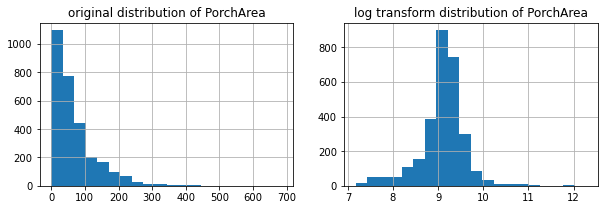

In [332]:
# check if the newly created feature should be log transformed as well
plot_logpair('PorchArea')

In [333]:
# log transforming the PorchArea feature
df['PorchArea_log'] = np.log(df['PorchArea'] +1)

In [343]:
# adding nr of baths per bedroom feature
df['BathPerBedroom'] = np.where(df.BedroomAbvGr>0, df.NrBath / df.BedroomAbvGr,0)

In [344]:
df.BathPerBedroom.describe()

count   2919.000
mean       0.645
std        0.265
min        0.000
25%        0.500
50%        0.625
75%        0.833
max        2.000
Name: BathPerBedroom, dtype: float64

In [335]:
feats = feats + ['PorchArea_log', 'BathPerBedroom', 'LivingSpcPerRoom', 'BathAgg', 'NrBath', 'NrBsmtBath']

In [345]:
# check model after adding newly created features
check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=400, learning_rate=0.3, random_state=0))

30619.301735119247


Weight,Feature
0.2033,CentralAir_cat
0.1713,GarageCars
0.0672,GrLivArea_log
0.0656,BathAgg
0.0641,Fireplaces
0.0503,TotalBsmtSF_log
0.0412,KitchenQual_cat
0.0228,YearBuilt
0.0226,MSZoning_cat
0.0161,KitchenAbvGr


In [351]:
print('The introduction of aggregated features improved the error by {:.2f}'.format(baseline_rmse - 30619.301735119247))
print('The current model also improved slightly compared to previous model - by {:.2f}'.format(30620.91 - 30619.301735119247))

The introduction of aggregated features improved the error by 562.12
The current model also improved slightly compared to previous model - by 1.61
